In [1]:
import thinkbayes
import pandas as pd
import seaborn as sns

%pylab inline
pylab.rcParams['figure.figsize'] = (16, 8)

Populating the interactive namespace from numpy and matplotlib


# 예측
___
## 1. 보스턴 브루인스 문제

>- 2010-11 하키리그 결승전에서 보스턴 브루인스와 벤쿠버 캐넉스를 만남
>- 7전 4선승제에서 처음 두 경기를 0-1, 2-3으로 패배
>- 이후 두 경기를 8-1, 4-0으로 승리
>- 다음 경기를 이길 확률과, 결승전을 승리할 확률은 어떻게 되는가?

- 위 문제에 답하기 위해선 두가지 가정을 해야 함
    > 1. 경기 중 어떤 때든 골이 들어갈 확률은 동일하다고 보는 포아송 분포를 따름  
    > 2. 특정 상대에 대해 각 팀의 장기적 평균 골 수는 $\lambda$를 따름

- 위 문제에 답하기 위한 절차는 다음과 같음
> 1. $\lambda$에 대한 사전 분포를 고르기 위해 전 게임에 대한 통계를 확인  
> 2. 각 팀에 대한 $\lambda$ 추정을 위해 처음 네 게임의 점수를 사용  
> 3. $\lambda$의 사후 분포를 통해 각 팀 별 골의 분포 골 차이의 분포, 각 팀이 다음에 이길 확률을 계산  
> 4. 각 팀이 이번 시리즈에서 이길 확률을 계산

___
- 사전분포는 NHL 2010-11 시즌의 팀장 평균 골 수를 사용하여 근사
- 분포는 $N(2.8, 0.3)$의 가우시안 분포를 따름
- 가우시안 분포는 연속형이나, `thinkbayes.MakeGaussianPmf`를 통해 이산 Pmf로 추정
- 여기서 `mu`는 평균, `sigma`는 표준편차, `num_sigma`는 표준편차의 배수('2'sigma, '6'sigma), `n`은 이산 Pmf의 범위 갯수
```python
def MakeGaussianPmf(mu, sigma, num_sigmas, n = 101):
    pmf = Pmf()
    low = mu - num_sigmas * sigma
    high = mu + num_sigmas * sigma
    
    for x in np.linspace(low, high, n):
        p = scipy.stats.norm.pdf(mu, sigma, x)
        pmf.Set(x, p)
    pmf.Normalize()
    return pmf
```

- 하키 문제로 돌아가서 $\lambda*$에 대한 suite의 정의는 아래와 같이 내릴 수 있음
- 사전분포는 평균 2.7에 표준편차가 0.3인 가우시안 분포를 따르고, 4 sigma의 범위로 pmf를 구성

In [2]:
class Hockey(thinkbayes.Suite):
    
    def __init__(self):
        pmf = thinkbayes.MakeGaussianPmf(mu = 2.7, sigma = 0.3, num_sigmas= 4)
        thinkbayes.Suite.__init__(self, pmf)

Text(0.5,1,'Prior of $\\lambda$ following $N(2.7,0.3)$\n')

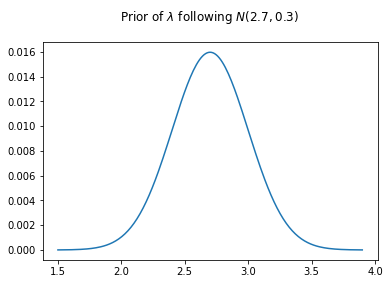

In [3]:
bins = []
vals = []
for i in Hockey().Items():
    x, y = i
    bins.append(x)
    vals.append(y)
    

sns.lineplot(x = bins, y = vals)
plt.title('Prior of $\lambda$ following $N(2.7,0.3)$\n')

___
## 2. 포아송 프로세스

- 포아송 프로세스는 베르누이 프로세스의 연속형으로, 사건이 어떤 시점에서든 동일한 확률로 발생할 수 있음
- 가게에 손님이 방문 할 확률, 버스정류장에 버스가 도착할 확률, 하키 게임에서 골이 들어갈 확률 등이 이에 속할 수 있음
- 물론, 현실에서는 시간에 따라 확률이 다르지만 모든 모델이 단순화에서 기인한 만큼, 본 경우는 하키게임을 포아송 프로세스로 단순화
- 단순화된 포아송 프로세스를 활용한 모델링을 사용하게 되면, 보다 효율적으로 '게임당 골'의 분포를 계산할 수 있고, '골 간의 시간' 분포도 계산할 수 있음 (포아송 PMF로)

- 게임 당 평균 골 수($\lambda$)가 `lam`이라면, `lam`의 분포는 포아송 PMF로 주어짐 (`thinkbayes.EvalPoissonPmf`)
```python
def EvalPoissonPmf(lam, k):
    return (lam)**k * math.exp(-lam)/math.factorial(k)
```

- '골 간의 시간' 분포는 지수 PDF를 따름 (`thinkbayes.EvalExponentialPdf`)
```python
def EvalExponentialPdf(lam, x):
    return lam * math.exp(-lam*x)
```

___
## 3. 사후 분포

- 게임에서 $k$개의 골을 넣을 때, `lam`의 가설값을 갖는 `Hockey` 객체의 우도를 구할 수 있음 (갱신)  
```python

 #class Hockey
    def Likelihood(self, data, hypo):
        lam = hypo
        k = data
        like = thinkbayes.EvalPoissonPmf(lam, k)
        return like
```
    

In [4]:
class Hockey(thinkbayes.Suite):
    
    def __init__(self):
        pmf = thinkbayes.MakeGaussianPmf(mu = 2.7, sigma = 0.3, num_sigmas= 4)
        thinkbayes.Suite.__init__(self, pmf)
        
    
    def Likelihood(self, data, hypo):
        lam = hypo
        k = data
        like = thinkbayes.EvalPoissonPmf(k, lam)
        return like

- 위의 예제를 우도로 변환하여 갱신 (0-1, 2-3, 8-1, 4-0)
- lam의 근사값은(MaximumLikelihood) Canucks의 경우 2.52, Bruins의 경우 2.80임

In [5]:
bruins = Hockey()
bruins.UpdateSet([0, 2, 8, 4])
canucks = Hockey()
canucks.UpdateSet([1, 3, 1, 0])

0.0005725202359080637

Text(0.5,1,'Posteriors of number of goals per game after 4 games\n')

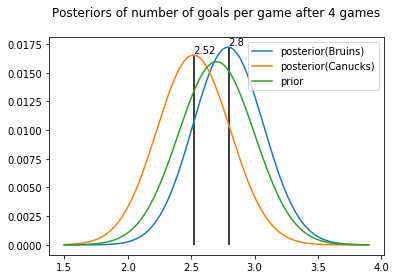

In [44]:
sns.lineplot(list(bruins.d.keys()), list(bruins.d.values()), label = 'posterior(Bruins)')
sns.lineplot(list(canucks.d.keys()), list(canucks.d.values()), label = 'posterior(Canucks)')
sns.lineplot(x = bins, y = vals, label = 'prior')

plt.vlines(x = bruins.MaximumLikelihood(), ymin = 0, ymax = max(bruins.d.values()))
plt.text(x = bruins.MaximumLikelihood(), y = max(bruins.d.values())*1.01, s = round(bruins.MaximumLikelihood(),2))
plt.vlines(x = canucks.MaximumLikelihood(), ymin = 0, ymax = max(canucks.d.values()))
plt.text(x = canucks.MaximumLikelihood(), y = max(canucks.d.values())*1.01, s = round(canucks.MaximumLikelihood(),2))

plt.title('Posteriors of number of goals per game after 4 games\n')

___
## 4. 골의 분포

- 각 팀이 다음 경기에서 이길 확률을 계산하려면 각 팀의 골의 분포를 계산해야 함
- 만약 $\lambda$ 값을 정확히 알고 있다면 포아송 분포를 다시 사용할 수 있음
- thinkbayes에서는 0부터 high까지를 범위로, 포아송 분포의 절단 근사값을 계산하는 메서드를 제공
```python
def MakePoissonPmf(lam, high):
    pmf = Pmf()
    for k in range(0, high+1):
        p = EvalPoissonsPmf(lam, k)
        pmf.Set(k, p)
    pmf.Normalize()
    return pmf
    ```

- $\lambda$가 3.4라면, 다음과 같이 계산 가능
- 한게임에서 10골 이상 나올 가능성은 매우 낮으므로 high를 10으로 설정
```python
lam = 3.4
goal_dist = thinkbayes.MakePoissonPmf(lam, 10)
```

- 문제는, $\lambda$를 정확하게 모른다는 것인데, 대신 $\lambda$가 가능한 값들에 대한 분포가 있음
- 따라서, 각 $\lambda$에 대해 포아송 분포를 구하고, 골 의 전체 분포는 포아송 분포의 혼합형으로, $\lambda$의 분포 확률에 따라 가중치를 부여
- $\lambda$의 사후 분포에 대해 골의 분포를 생성하는 코드는 다음과 같음

In [39]:
def MakeGoalPmf(suite):
    '''
    lambda 별로 0-10 pmf를 만들고,
    각 값(이 경우 정수)마다 확률과 lambda 별 가중치를 곱하여 합산
    합산한 결과값은 정규화 하여 혼합 분포 추정

    책의 예제는 python 2.5에서는 작동할지 몰라도 Set 안에 pmf object가 들어가면 dict key에 object를 지정할 수 없어 에러 반환
    '''
    
    metapmf = thinkbayes.Pmf()

    for lam, weight in suite.Items():
        pmf = thinkbayes.MakePoissonPmf(lam, 10)
        for val, prob in pmf.Items():
            metapmf.Incr(val, prob*weight)
    
        
    metapmf.Normalize()
    return metapmf

#def MakeGoalPmf(suite):
#    metapmf = thinkbayes.Pmf()
#    
#    for lam, prob in suite.Items():
#        pmf = thinkbayes.MakePoissonPmf(lam, 10)
#        metapmf.Set(pmf, prob)    -->    Set(x, y) 는 dict[x] = y를 수행하는데, python 3.0+ 에서는 x에 object가 들어가면 에러 발생 
#        
#    mix = thinkbayes.MakeMixture(metapmf.d)
#    return mix

In [29]:
bruins_goal = MakeGoalPmf(bruins)
canucks_goal = MakeGoalPmf(canucks)

(0, 0.25)

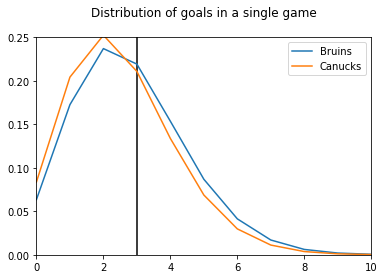

In [43]:
sns.lineplot(x = list(bruins_goal.d.keys()), y = list(bruins_goal.d.values()), label = 'Bruins')
sns.lineplot(x = list(canucks_goal.d.keys()), y = list(canucks_goal.d.values()), label = 'Canucks')
plt.title('Distribution of goals in a single game\n')
plt.vlines(x = 3, ymin = 0, ymax = 0.25)
plt.xlim(0,10)
plt.ylim(0, 0.25)

- 위 그래프를 해석하자면, Bruins는 다음 게임에서 3점 이상으로 득점할 확률이 Canunkcs보다 높고, 그 이하로 득점할 확률은 Canunkcs보다 낮음

___
## 5. 이길 확률

- 승패 확률을 구하는 것은 골수 차이의 분포가 ($x$가) 0보다 크거나 작을 경우를 구하는 것과 동일
- 골 수 차이는 위에서 구해 둔 분포로 계산 가능

Text(0.5,1,'Distribution of goal difference(or winning probability)\n')

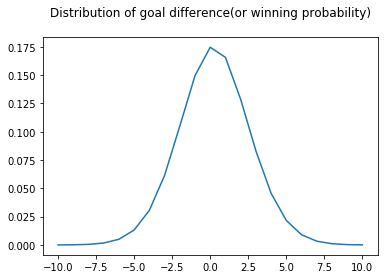

In [51]:
diff = bruins_goal - canucks_goal

sns.lineplot(x = list(diff.d.keys()), y = list(diff.d.values()))
plt.xlim = (-10, 10)
plt.title('Distribution of goal difference(or winning probability)\n')

In [53]:
round(diff.ProbGreater(0),2), round(diff.Prob(0),2), round(diff.ProbLess(0),2)

(0.46, 0.17, 0.37)

- Bruins가 승리할 확률은 0.46, 비길 확률은 0.17, 질 확률은 0.37로 추정할 수 있음

___
## 6. 서든 데스

- 서든데스에서 중요한 통계치는, 골 수가 아니라 골을 넣기까지 걸리는 시간임
- 골 수가 Poisson을 따른다면 골간의 시간은 지수함수를 따른다고 볼 수 있음
- `thinkbayes.MakeExponentialPmf`를 사용하여 다음과 같이 골 간의 시간을 계산 가능
- 2경기 이상 서든데스 갈 확률은 적으므로 high는 2를 가정

In [55]:
lam = 3.4
time_dist = thinkbayes.MakeExponentialPmf(lam, high = 2, n = 101)

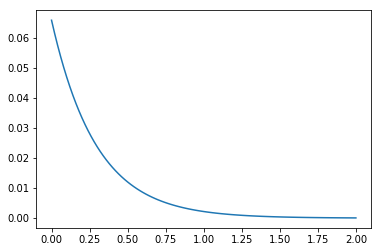

In [56]:
sns.lineplot(x = list(time_dist.d.keys()), y = list(time_dist.d.values()))

- 앞선 예제와 동일하게 가능한 값들의 사후분포만 있기에, 각 값별로 분포를 구해서 혼합분포를 계산

In [57]:
def MakeGoalTimePmf(suite):
    '''
    위의 MakeGoalPmf 참조
    '''
    
    metapmf = thinkbayes.Pmf()

    for lam, weight in suite.Items():
        pmf = thinkbayes.MakeExponentialPmf(lam, high = 2, n = 2001)
        for val, prob in pmf.Items():
            metapmf.Incr(val, prob*weight)
    
        
    metapmf.Normalize()
    return metapmf

In [58]:
bruins_time = MakeGoalTimePmf(bruins)
canucks_time = MakeGoalTimePmf(canucks)

Text(0.5,0,'Game until goal')

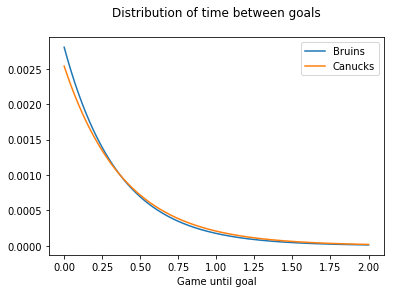

In [68]:
sns.lineplot(x = list(bruins_time.d.keys()), y = list(bruins_time.d.values()), label = 'Bruins')
sns.lineplot(x = list(canucks_time.d.keys()), y = list(canucks_time.d.values()), label = 'Canucks')
plt.title('Distribution of time between goals\n')
plt.xlabel('Game until goal')

In [72]:
thinkbayes.PmfProbLess(bruins_time, canucks_time)    ## bruins_time이 canucks_time보다 작을 확률

0.5241042376724303

- Bruins가 Canucks보다 먼저 골을 넣을 확률은 52%임

___
- 다음 경기에서 이길 확률은 다음 두 경우로 구분할 수 있음:  
    1) 경기 시간 내 이길 확률
    ```python
    diff.ProbGreater(0)
    ```
    2) 서든데스에서 이길 확률
    ```python
    diff.Prob(0) * thinkbayes.PmfProbLess(bruins_time, canucks_time)
```

In [74]:
p_win1 = diff.ProbGreater(0)
p_win1

0.4584444631603826

In [75]:
p_win2 = diff.Prob(0) * thinkbayes.PmfProbLess(bruins_time, canucks_time)
p_win2

0.09152324406242175

In [78]:
p_win = p_win1 + p_win2
p_win

0.5499677072228044

- Bruins가 다음 경기에서 이길 확률은 약 55.0%로 추정 가능

___
- 시리즈에서 이길 확률은 다음 두 경우로 구분할 수 있음:  
    1) 두경기 먼저 이길 경우
    ```python
    p_win **2
```
    2) 한경기 씩 이기고 진 후 마지막 경기를 이기는 경우
    ```python
    2 * p_win * (1-p_win) * p_win # win-lose-win, lose-win-win
```

In [80]:
p_series = p_win**2 + 2* p_win * (1-p_win) * p_win
p_series

0.5747020449130849

- Bruins가 시리즈에서 이길 확률은 약 57.5% 추정 가능하며, 실제로 2011년 우승 팀은 Bruins 였음